# This script fits a linear regression for each LR pair and combine to a big table

In [4]:
import numpy as np
import csv
import pickle
import matplotlib
import math
import pandas as pd
import matplotlib
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter
from scipy.stats import chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import ast

In [5]:
def readCsv(x):
  """Parse file."""
  #colNames = ["method", "benchmark", "start", "end", "time", "memory"]
  df = pd.read_csv(x, sep=",")

  return df

def preprocessDf(df):
  """Transform ligand and receptor columns."""
  df["ligand-receptor"] = df["ligand"] + '-' + df["receptor"]
  df["component"] = df["component"] #.astype(str).str.zfill(2)

  return df

In [6]:
# Load subtype label
# subtype_label_file='/Users/victoriagao/local_docs/schwartz_data/PDAC_64630_subtype.csv'
subtype_label_file='/Users/victoriagao/Documents/MSc/Schwartz_lab/experiment_data/Deisha/PDAC_64630/fractional_abundances_by_spot.csv'
subtype_abundance_df = readCsv(subtype_label_file)
# subtype_label=[]
# with open(subtype_label_file) as file:
#     csv_file = csv.reader(file, delimiter=",")
#     for line in csv_file:
#         subtype_label.append(line)

# barcode_subtype=dict()
# for i in range(1,len(subtype_label)):
#     barcode_subtype[subtype_label[i][0]]= subtype_label[i][1]

# Load NEST output 
df = readCsv("/Users/victoriagao/local_docs/NEST/output/From_Fatema/NEST_combined_output_PDAC_64630.csv")
output_processed = preprocessDf(df)

### Build feature matrix

In [7]:
### Merge NEST output with subtype label, and filter out the spots that are not in the subtype label
matched_spots_df_sender = pd.merge(output_processed, subtype_abundance_df, left_on='from_cell', right_on='SpotID')
matched_spots_df_receiver = pd.merge(output_processed, subtype_abundance_df, left_on='to_cell', right_on='SpotID')
matched_spots_df_total_raw = pd.concat([matched_spots_df_sender, matched_spots_df_receiver])


In [8]:
matched_spots_df_total_raw

,from_cell,to_cell,ligand,receptor,attention_score,component,from_id,to_id,ligand-receptor,SpotID,...,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
0,ACGCGCTACACAGGGT-1,AAACCGGGTAGGTACC-1,LGALS3,NPTN,0.911919,2,132,0,LGALS3-NPTN,ACGCGCTACACAGGGT-1,...,0.2,0.0,0.00,0.0,0.0,0.20,0.0,0.0,0.60,0.0
1,TCTTACTTATGCCTCT-1,AAAGTGTGATTTATCT-1,FN1,RPSA,0.929988,6,1228,9,FN1-RPSA,TCTTACTTATGCCTCT-1,...,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.00,0.0
2,AGTCTCACAAGACTAC-1,AAATTGATAGTCCTTT-1,PTPRF,RACK1,0.911508,10,228,15,PTPRF-RACK1,AGTCTCACAAGACTAC-1,...,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.00,0.0
3,GTGGGCTTAGACACAC-1,AACAACTGGTAGTTGC-1,FN1,RPSA,0.923395,11,992,17,FN1-RPSA,GTGGGCTTAGACACAC-1,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,CCACAGTACCCATCCT-1,AACCGCTAAGGGATGC-1,FN1,RPSA,0.929303,16,425,23,FN1-RPSA,CCACAGTACCCATCCT-1,...,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,AACGTCAGACTAGTGG-1,TTGGCTCGCATGAGAC-1,TGFB1,EGFR,0.839991,17,31,1389,TGFB1-EGFR,TTGGCTCGCATGAGAC-1,...,0.0,0.0,0.00,0.0,0.0,0.75,0.0,0.0,0.25,0.0
1089,AGATTATAGGACGTTT-1,TTGTAATCCGTACTCG-1,TGFB1,ITGB5,0.829314,9,184,1394,TGFB1-ITGB5,TTGTAATCCGTACTCG-1,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1090,AGATTATAGGACGTTT-1,TTGTAATCCGTACTCG-1,TGFB1,SDC2,0.855152,9,184,1394,TGFB1-SDC2,TTGTAATCCGTACTCG-1,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1091,GAGAGGTGCATTCTGG-1,TTGTTTCCATACAACT-1,TGFB1,EGFR,0.830097,2,715,1404,TGFB1-EGFR,TTGTTTCCATACAACT-1,...,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.00,0.0


In [9]:
# filter out the LR that only appeared once
matched_spots_df_total = matched_spots_df_total_raw[matched_spots_df_total_raw['ligand-receptor'].duplicated(keep=False)] 
# Take only top 50% LR by frequency
lr_counts = matched_spots_df_total['ligand-receptor'].value_counts()
threshold = lr_counts.quantile(0.50)  # gives the value at the 50th percentile
top_percent_lrs = lr_counts[lr_counts >= threshold].index
matched_spots_df_total = matched_spots_df_total[matched_spots_df_total['ligand-receptor'].isin(top_percent_lrs)]
# Delete some columns
matched_spots_df_total = matched_spots_df_total.drop(columns=['from_cell', 'to_cell', 'ligand', 'receptor', 'attention_score', 'component', 'from_id','to_id','SpotID'])

In [10]:
matched_spots_df_total

,ligand-receptor,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
0,LGALS3-NPTN,0.0,0.00,0.00,0.0,0.00,0.2,0.0,0.00,0.0,0.0,0.20,0.0,0.0,0.60,0.0
1,FN1-RPSA,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.00,0.0
2,PTPRF-RACK1,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.00,0.0
3,FN1-RPSA,0.0,0.00,1.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,FN1-RPSA,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,TGFB3-SDC4,0.0,0.25,0.50,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.25,0.0
1087,TGFB1-ITGB5,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.75,0.0,0.0,0.25,0.0
1088,TGFB1-EGFR,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.75,0.0,0.0,0.25,0.0
1089,TGFB1-ITGB5,0.0,0.00,0.75,0.0,0.25,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0


In [110]:
len(matched_spots_df_total_raw['SpotID'].unique())


721

### Fit logistic regression and outputs a big coefficient table for all regressions

In [11]:
unique_lr_pairs = matched_spots_df_total['ligand-receptor'].unique() # Get unique ligand-receptor pairs

#### Run this if want to fit BINARY CLASSIFICATION FOR EACH LR ("yes"/"no")

##### WITHOUT splitting data

In [12]:
results = []

# Iterate through each unique ligand-receptor pair
for lr_pair in unique_lr_pairs:
    # Prepare the feature matrix X and the target vector y
    # get all the columns from matched_spots_df except for the 'from_cell', 'edge_rank' and 'ligand-receptor'
    # X_log_reg = matched_spots_df_total.drop(columns=["from_cell", "edge_rank", "ligand-receptor"])
    X_log_reg = matched_spots_df_total.drop(columns=["ligand-receptor"])
    y_binary = ["yes" if lr == lr_pair else "no" for lr in matched_spots_df_total["ligand-receptor"]]
    # print dimensions of X and y
    # print(X_log_reg.shape, len(y_binary))

    # print(Counter(y_binary))
    
    # Build and fit the logistic model
    model_log_reg = linear_model.LogisticRegression(solver='lbfgs')
    model_log_reg.fit(X_log_reg, y_binary)
    
    # Extract coefficients and score
    coef = model_log_reg.coef_[0]  # Coefficients for the features
    score = model_log_reg.score(X_log_reg, y_binary)  # Accuracy score for how the model is fitted
    
    # Append the results (including LR pair, coefficients, and score) to our results list
    results.append([lr_pair] + list(coef) + [score])

# Define the column names for our results DataFrame
columns = ['Ligand-Receptor'] + X_log_reg.columns.tolist() + ['Accuracy Score']


results_df = pd.DataFrame(results)
# results_df = pd.DataFrame(results, columns=columns)

results_df

##### Run this if want to split data before fitting

In [43]:
results = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Iterate through each unique ligand-receptor pair
for lr_pair in unique_lr_pairs:
    # Prepare the feature matrix X and the target vector y
    # get all the columns from matched_spots_df except for the 'from_cell', 'edge_rank' and 'ligand-receptor'
    X_log_reg = matched_spots_df.drop(columns=["from_cell", "ligand-receptor"])
    y_binary = ["yes" if lr == lr_pair else "no" for lr in matched_spots_df["ligand-receptor"]]

    # Randomly undersample the majority class
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_log_reg, y_binary)
    # print(f"original x_log_reg: {X_log_reg.iloc[np.array(y_binary) == 'yes', :]}")
    # print(f"resampled x_log_reg: {X_resampled.iloc[np.array(y_resampled) == 'yes', :]}")
    # print(Counter(y_resampled))
    
    # Extract coefficients and score
    coef = model_log_reg.coef_[0]  # Coefficients for the features

    # Calculate accuracy score
    n_scores = cross_val_score(model_log_reg, X_resampled, y_resampled, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(n_scores)

    # Calculate sensitivity
    y_pred = model_log_reg.predict(X_resampled)
    tn, fp, fn, tp = confusion_matrix(y_resampled, y_pred).ravel()
    sensitivity = tp / (tp + fn)

    # Use f string to print the sensitivity
    # print(f"Sensitivity for {lr_pair} :{sensitivity}")
    # print(classification_report(y_test, y_pred))
    
    # Append the results (including LR pair, coefficients, and score) to our results list
    results.append([lr_pair] + list(coef) + [score] + [sensitivity])

# Define the column names for our results DataFrame
columns = ['Ligand-Receptor'] + X_log_reg.columns.tolist() + ['Accuracy Score'] + ['Sensitivity']

results_df = pd.DataFrame(results)
# results_df = pd.DataFrame(results, columns=columns)

results_df

#### MNL for LR, multiclass labels

In [12]:
# Create X and y for multiclass classification
X = matched_spots_df_total.drop(columns=["ligand-receptor"])
y_multiclass = matched_spots_df_total["ligand-receptor"]
model_log_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42) # set seed for reproducibility
model_log_multi.fit(X, y_multiclass)


LogisticRegression(multi_class='multinomial', random_state=42)

In [13]:
# Extract coefficients and score
coef = model_log_multi.coef_  # Coefficients for the features
score = model_log_multi.score(X, y_multiclass)  # Accuracy score for how the model is fitted
coef

array([[-0.08778501,  0.51908635, -0.33169017, ..., -0.1280459 ,
        -0.15633481, -0.11051622],
       [-0.0569539 , -0.33575522, -0.67683952, ..., -0.16914658,
        -0.15362189,  0.09842878],
       [ 0.38867043, -0.10206781,  0.17634724, ..., -0.39999189,
        -0.36279891, -0.20436544],
       ...,
       [-0.46630998, -1.43325808,  2.04598145, ..., -0.10777587,
         0.57418776, -0.21456414],
       [-0.06568734,  0.76322475, -0.78930403, ..., -0.15981719,
        -0.20360742, -0.0861228 ],
       [-0.16274394, -0.19961196, -0.37077748, ...,  0.5203083 ,
        -0.20291478, -0.34356543]])

In [14]:
#### Saving the coefficients to table outputs

results = pd.DataFrame()
# Feature names (LR pairs)
feature_names = matched_spots_df_total.columns.drop("ligand-receptor")

# Class names (assuming model.classes_ gives you the class names in the order they're in the coefficients matrix)
class_names = model_log_multi.classes_

# Dictionary to hold dataframes for each class
coefficients_dfs = {}

for index, class_name in enumerate(class_names):
    coefs = model_log_multi.coef_[index]
    # Create a DataFrame for each class
    class_df = pd.DataFrame({
        f"{class_name}": coefs
    }, index=feature_names)
    
    
    # Save the DataFrame in the dictionary
    coefficients_dfs[class_name] = class_df

    # transpose the dataframe
    class_df = class_df.T

    # Append class_df every iteration
    results = pd.concat([results, class_df])


In [15]:
results

,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
ADAM9-ITGA6,-0.087785,0.519086,-0.331690,-0.504347,-0.081472,0.548091,0.733759,0.170688,-0.020335,-0.114876,-0.424428,-0.021695,-0.128046,-0.156335,-0.110516
AIMP1-RACK1,-0.056954,-0.335755,-0.676840,-0.388632,1.022493,-0.265027,-0.269936,-0.047267,-0.014004,-0.061029,1.279385,-0.010273,-0.169147,-0.153622,0.098429
APOE-SDC1,0.388670,-0.102068,0.176347,-0.740910,2.193770,-0.181711,0.240097,-0.112222,-0.065767,-0.188847,-0.584079,-0.035632,-0.399992,-0.362799,-0.204365
APOE-SDC4,0.422485,0.160770,-0.850236,-0.845577,0.253047,0.483763,-0.347137,0.123772,-0.061873,-0.288911,-0.326397,-0.060885,-0.344089,1.929102,-0.192099
ARF1-LRP5,-0.057488,1.871900,-0.734489,-0.348307,-0.272370,0.845583,-0.125436,-0.036658,-0.015967,-0.094756,-0.626182,-0.016056,-0.163493,-0.209221,-0.078468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THBS2-CD47,-0.149077,0.431387,0.407948,-0.236508,0.132946,-0.016902,0.550088,-0.086547,-0.030800,-0.169347,-0.350206,-0.029184,-0.153549,-0.121875,-0.169993
THBS2-LRP1,-0.058808,-0.606577,1.817503,-0.284573,-0.246044,-0.336853,-0.204759,-0.027436,-0.007585,-0.045726,-0.241059,-0.007365,-0.128133,0.105708,0.179226
TIMP1-LRP1,-0.466310,-1.433258,2.045981,0.422807,0.929224,-0.445059,-0.969205,-0.223088,-0.066307,-0.291390,0.319848,-0.045786,-0.107776,0.574188,-0.214564
TNFSF13-TNFRSF1A,-0.065687,0.763225,-0.789304,0.855198,-0.297144,-0.544648,-0.368507,-0.036808,-0.017326,1.603576,-0.662371,-0.014654,-0.159817,-0.203607,-0.086123


#### Save results output table

In [59]:
# Save the results to a CSV file
results.to_csv("/Users/victoriagao/local_docs/NEST/stored_variables/64630_Celltype_LR_MNL__SenderORReceiver.csv", index=True)


### Calculate some statistics

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.stats import chi2

In [17]:
# Define functions for bootstrapping and calculating p-values

def fit_model(X, y):
    model = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
    model.fit(X, y)
    return model

# returns the coefficients using bootstrapping
def get_bootstrap_coefficients(X, y, n_iterations, model):
    n_classes, n_features = model.coef_.shape
    bootstrap_coefs = np.zeros((n_iterations, n_classes, n_features))
    for i in range(n_iterations):
        try:
            X_sample, y_sample = resample(X, y)
            model.fit(X_sample, y_sample)
            if model.coef_.shape == (n_classes, n_features):
                bootstrap_coefs[i] = model.coef_
        except ValueError as e:
            continue
    return bootstrap_coefs

def calculate_standard_errors(bootstrap_coefs):
    return np.std(bootstrap_coefs, axis=0)

def calculate_bootstrap_coefficients_mean(bootstrap_coefs):
    return np.mean(bootstrap_coefs, axis=0)

def calculate_confidence_intervals(bootstrap_coefs, confidence_level=0.95):
    # Calculate the lower and upper percentiles to establish the confidence interval
    lower_percentile = (1 - confidence_level) / 2.0 * 100
    upper_percentile = (1 + confidence_level) / 2.0 * 100
    # return the confidence intervals as a pair of values for each coefficient
    confidence_intervals = np.percentile(bootstrap_coefs, [lower_percentile, upper_percentile], axis=0) 
    return confidence_intervals

def calculate_p_values(weights, bootstrap_standard_errors):
    wald_stats = (weights / bootstrap_standard_errors) ** 2
    p_values = 1 - chi2.cdf(wald_stats, 1)
    return p_values




In [18]:
bootstrap_coefficients = get_bootstrap_coefficients(X, y_multiclass, 1000, model_log_multi)
coefficient_confidence_intervals = calculate_confidence_intervals(bootstrap_coefficients)
standard_errors = calculate_standard_errors(bootstrap_coefficients)
p_values = calculate_p_values(coef, standard_errors)


In [19]:
bootstrap_coefficients.shape

(1000, 81, 15)

#### EVERYTHING together: output a MNL coefficient table with confidence intervals and p-values



In [20]:

# Assuming model_log_multi, class_names, feature_names are already defined
# Initialize an empty DataFrame to store results
coefficient_output = pd.DataFrame()
pvalue_output = pd.DataFrame()
confidence_interval_output = pd.DataFrame()
mean_output = pd.DataFrame()

# Generate bootstrap coefficients for CI and p-values
bootstrap_coefficients = get_bootstrap_coefficients(X, y_multiclass, 1000, model_log_multi)
bootstrap_se = calculate_standard_errors(bootstrap_coefficients)
confidence_intervals = calculate_confidence_intervals(bootstrap_coefficients)
coefficient_mean = calculate_bootstrap_coefficients_mean(bootstrap_coefficients)
p_values = calculate_p_values(model_log_multi.coef_, bootstrap_se)

for index, class_name in enumerate(class_names):
    coefs = model_log_multi.coef_[index]
    cis = confidence_intervals[:, index, :]  # CI for the current class
    combined_cis = [f"({low:.2f}, {high:.2f})" for low, high in zip(cis[0], cis[1])]
    p_vals = p_values[index, :]  # P-values for the current class
    coef_mean = coefficient_mean[index, :]  # Mean of the coefficients for the current class

    # Create statistics for each LR with coefficients, CIs, means and p-values
    coefficient_df = pd.DataFrame({
        f"{class_name}_coef": coefs,
    }, index=feature_names)

    pvalue_df = pd.DataFrame({
        f"{class_name}_p_value": p_vals
    }, index=feature_names)

    confidence_interval_df = pd.DataFrame({
        f"{class_name}_CI": combined_cis
    }, index=feature_names)

    coefficient_mean_df = pd.DataFrame({
        f"{class_name}_mean": coef_mean
    }, index=feature_names)


    # Append the coeff, pvalue and CI df every iteration
    coefficient_output = pd.concat([coefficient_output, coefficient_df], axis=1)
    pvalue_output = pd.concat([pvalue_output, pvalue_df], axis=1)
    confidence_interval_output = pd.concat([confidence_interval_output, confidence_interval_df], axis=1)
    mean_output = pd.concat([mean_output, coefficient_mean_df], axis=1)


In [21]:
# Transpose the dataframe for consistent formatting
coefficient_output = coefficient_output.T.reset_index().rename(columns={"index": "LR_pair"})
pvalue_output = pvalue_output.T.reset_index().rename(columns={"index": "LR_pair"})
confidence_interval_output = confidence_interval_output.T.reset_index().rename(columns={"index": "LR_pair"})
mean_output = mean_output.T.reset_index().rename(columns={"index": "LR_pair"})

In [115]:
pvalue_output
pvalue_output.to_csv("/Users/victoriagao/local_docs/NEST/stored_variables/new_64630_Celltype_LR_MNL__SenderORReceiver_pval.csv", index=True)

: 

In [23]:
coefficient_output

,LR_pair,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
0,ADAM9-ITGA6_coef,-0.118595,0.899677,-0.183637,-0.812770,-0.170081,0.966544,0.415069,0.039954,-0.017743,-0.161325,-0.305383,-0.034859,-0.260799,-0.123060,-0.141904
1,AIMP1-RACK1_coef,-0.078935,0.143664,-0.787682,-0.496294,0.103871,-0.155567,-0.336688,-0.076460,-0.009061,-0.099316,1.784149,-0.016433,-0.217836,-0.202950,0.424345
2,APOE-SDC1_coef,0.580610,-0.875036,0.076342,-0.596754,2.059144,0.007637,0.129672,-0.137615,-0.039285,-0.228061,-0.074170,-0.045727,-0.298761,-0.291378,-0.231471
3,APOE-SDC4_coef,0.256211,0.274314,-1.399865,-0.829983,0.505919,0.209190,0.113720,0.133773,-0.033149,-0.279171,-0.034090,-0.058136,-0.249400,1.685286,-0.253894
4,ARF1-LRP5_coef,-0.084727,2.421408,-0.943297,-0.444079,-0.377496,1.406551,-0.349122,-0.062286,-0.023181,-0.153714,-0.742419,-0.029825,-0.210678,-0.317278,-0.116117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,THBS2-CD47_coef,-0.163701,0.306044,0.534742,-0.724169,-0.348520,1.054870,0.560452,-0.099283,-0.019098,-0.191441,-0.584378,-0.044265,-0.227707,0.134626,-0.180026
77,THBS2-LRP1_coef,-0.092753,-0.652262,2.741929,-0.280077,-0.300956,-0.395705,-0.205430,-0.035263,-0.003991,-0.058341,-0.409419,-0.008594,-0.144468,-0.148238,-0.079283
78,TIMP1-LRP1_coef,-0.543906,-0.848266,2.111506,0.598772,1.133090,-0.879796,-0.957432,-0.263526,-0.042739,-0.383691,0.356666,-0.051088,-0.035031,0.317738,-0.489335
79,TNFSF13-TNFRSF1A_coef,-0.054025,0.941380,-0.668139,-0.263253,-0.234375,-0.455570,-0.289982,-0.036023,-0.008680,1.908965,-0.500471,-0.012966,-0.122239,-0.162988,-0.069269


In [177]:
coefficient_output
# Save the results to a CSV file
coefficient_output.to_csv("/Users/victoriagao/local_docs/NEST/stored_variables/new_64630_Celltype_LR_MNL__SenderORReceiver.csv", index=True)

In [24]:
# sort coefficient_output by Fibroblast values
# coefficient_sorted = coefficient_output.reindex(coefficient_output.sort_values(by='Fibroblast', ascending=False).index)
# coefficient_sorted = coefficient_output.sort_values(by='Fibroblast', ascending=False)

# coefficient_sorted

# Get index of the top 10 features for each cell type
top_10_indices = {}
for column in coefficient_output.columns:
    # Sort the column in descending order
    sorted_df = coefficient_output.sort_values(by=column, ascending=False)
    # Get the indices of the top 10 values
    top_10_indices[column] = sorted_df.index[:10].tolist()


In [25]:
top_10_indices

{'LR_pair': [80, 79, 78, 77, 76, 75, 74, 73, 72, 71],
 'Endothelial': [22, 19, 43, 42, 2, 41, 32, 52, 3, 59],
 'ClassicA': [55, 38, 4, 9, 57, 36, 52, 53, 28, 33],
 'Fibroblast': [74, 77, 66, 25, 18, 78, 26, 75, 17, 67],
 'Duct': [8, 37, 59, 30, 24, 40, 6, 34, 12, 52],
 'Endocrine': [2, 70, 61, 78, 67, 63, 47, 5, 49, 42],
 'Mixed': [19, 50, 27, 4, 7, 80, 57, 45, 52, 76],
 'BasalB': [43, 41, 47, 42, 45, 12, 27, 26, 28, 46],
 'NKCell': [75, 25, 61, 49, 26, 68, 7, 19, 3, 80],
 'Acinar': [52, 61, 33, 14, 71, 69, 72, 64, 17, 77],
 'BasalA': [79, 54, 56, 44, 29, 8, 39, 52, 30, 68],
 'BPlasmaCell': [65, 16, 51, 25, 63, 1, 61, 59, 48, 62],
 'ClassicB': [60, 57, 14, 69, 71, 64, 72, 17, 65, 77],
 'TCell': [67, 75, 61, 59, 68, 22, 66, 70, 51, 80],
 'Macrophage': [3, 19, 58, 40, 51, 20, 35, 50, 10, 45],
 'Mast': [59, 25, 67, 51, 68, 52, 46, 7, 49, 1]}

In [26]:
# With the top 10 indices, get the corresponding confidence intervals and means for each cell type
top_10_confidence_intervals = {}
top_10_coef_means = {}
for cell_type, indices in top_10_indices.items():
    # Get the confidence intervals for the top 10 features
    top_10_confidence_intervals[cell_type] = confidence_interval_output.loc[indices]
    top_10_coef_means[cell_type] = mean_output.loc[indices]

# top_10_confidence_intervals['Fibroblast']
top_10_coef_means['Fibroblast']

,LR_pair,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
74,THBS1-LRP1_mean,-0.081627,-0.718908,2.019910,-0.324978,-0.329956,-0.410364,-0.248634,-0.042972,-0.009306,-0.054375,0.571281,-0.008663,-0.187133,-0.158434,-0.087851
77,THBS2-LRP1_mean,-0.055674,-0.570858,1.702853,-0.262880,-0.231652,-0.316769,-0.189566,-0.025827,-0.007154,-0.042684,-0.227682,-0.006802,-0.122190,0.102605,0.171515
66,TGFB1-ENG_mean,-0.294700,-1.183797,2.467478,-0.724945,0.438976,-0.389673,-0.634715,-0.143828,-0.032200,-0.138470,0.530448,-0.024929,0.496153,-0.277805,-0.074846
25,FN1-RPSA_mean,-0.612719,-2.121107,1.930032,-1.431736,-0.443356,-1.324644,-0.108634,1.117136,-0.098787,-0.364764,1.721859,-0.076528,0.918751,-0.230155,1.226430
18,COL1A1-SDC1_mean,-0.247678,0.986888,1.751130,-0.661208,0.038582,-0.533536,-0.375875,0.040393,-0.036694,-0.193645,-0.059566,-0.031695,0.084486,-0.498166,-0.253121
78,TIMP1-LRP1_mean,-0.438424,-1.369659,2.019394,0.382535,0.855655,-0.446841,-0.909104,-0.210732,-0.062007,-0.270739,0.317547,-0.041603,-0.121320,0.533393,-0.207285
26,FN1-SDC1_mean,-0.205412,0.529191,0.917073,-0.819215,0.318120,0.024487,1.199291,0.132018,-0.065251,-0.303482,-0.725693,-0.063459,0.066036,-0.612319,-0.345930
75,THBS1-SDC1_mean,-0.154546,-1.271192,1.466263,-1.151236,-0.082185,-1.418249,0.092570,0.720459,0.797586,-0.263332,0.727973,-0.050274,1.091098,-0.273604,-0.156612
17,COL1A1-ITGA5_mean,-0.059042,-0.682556,1.047999,-0.319330,-0.256046,-0.035313,-0.232704,-0.035665,0.309697,-0.052627,0.318828,-0.008931,0.159905,-0.136314,-0.072304
67,TGFB1-ITGB5_mean,0.341725,-2.761026,1.039045,-1.518133,0.467005,-1.178484,-0.309944,0.357118,-0.180949,-0.141581,1.098408,0.622790,1.531801,-0.104616,0.858656


In [27]:
# convert top_10_confidence_intervals['fibroblast'] to a dataframe
celltype_top_10_CI = pd.DataFrame(top_10_confidence_intervals['Fibroblast'])
celltype_top_10_coef_mean = pd.DataFrame(top_10_coef_means['Fibroblast'])

In [29]:

# Parse the elements in celltype_top_10_CI from string to tuple
def parse_ci(ci_str):
    return ast.literal_eval(ci_str)

confidence_df = pd.DataFrame()
coef_mean_df = pd.DataFrame()

# Apply the parse_ci function to all elements in celltype_top_10_CI
for col in celltype_top_10_CI.columns[1:]:  # Adjust this range according to your actual data structure
    confidence_df[col] = celltype_top_10_CI[col].apply(parse_ci)

for col in celltype_top_10_coef_mean.columns[1:]:  # Adjust this range according to your actual data structure
    coef_mean_df[col] = celltype_top_10_coef_mean[col].apply(lambda x: round(x, 2))

# add LR column to the confidence_df as the first column
confidence_df.insert(0, 'LR', celltype_top_10_CI['LR_pair'])
confidence_df['LR'] = confidence_df['LR'].str.replace(r'_CI', '')

coef_mean_df.insert(0, 'LR', celltype_top_10_coef_mean['LR_pair'])
coef_mean_df['LR'] = coef_mean_df['LR'].str.replace(r'_mean', '')

In [30]:
confidence_df

,LR,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
74,THBS1-LRP1,"(-0.13, 0.0)","(-0.94, 0.0)","(0.0, 2.72)","(-0.43, 0.0)","(-0.49, 0.0)","(-0.56, 0.0)","(-0.35, 0.0)","(-0.08, 0.0)","(-0.02, 0.0)","(-0.08, 0.0)","(-0.38, 1.52)","(-0.02, 0.0)","(-0.3, 0.0)","(-0.24, 0.0)","(-0.15, 0.0)"
77,THBS2-LRP1,"(-0.1, 0.0)","(-0.86, 0.0)","(0.0, 2.55)","(-0.41, 0.0)","(-0.39, 0.0)","(-0.5, 0.0)","(-0.3, 0.0)","(-0.05, 0.0)","(-0.02, 0.0)","(-0.07, 0.0)","(-0.42, 0.01)","(-0.02, 0.0)","(-0.22, 0.0)","(-0.13, 0.53)","(-0.06, 0.64)"
66,TGFB1-ENG,"(-0.44, 0.0)","(-1.58, 0.0)","(0.0, 3.15)","(-0.99, 0.0)","(-0.74, 1.61)","(-0.85, 0.08)","(-0.88, 0.0)","(-0.23, 0.0)","(-0.07, 0.0)","(-0.21, 0.0)","(-0.52, 1.4)","(-0.05, 0.0)","(-0.16, 1.35)","(-0.56, 0.1)","(-0.34, 0.36)"
25,FN1-RPSA,"(-0.91, 0.0)","(-2.72, 0.0)","(0.0, 2.47)","(-1.73, 0.0)","(-1.09, 0.16)","(-1.98, 0.0)","(-0.99, 0.75)","(0.0, 2.3)","(-0.2, 0.0)","(-0.53, 0.0)","(0.0, 2.25)","(-0.16, 0.0)","(-0.07, 1.92)","(-1.06, 0.63)","(-0.0, 2.29)"
18,COL1A1-SDC1,"(-0.36, 0.0)","(0.0, 1.72)","(0.0, 2.41)","(-1.02, 0.0)","(-0.8, 1.2)","(-1.31, 0.28)","(-0.86, 0.22)","(-0.17, 0.43)","(-0.07, 0.0)","(-0.29, 0.0)","(-0.94, 0.79)","(-0.06, 0.0)","(-0.43, 0.73)","(-0.67, 0.0)","(-0.37, 0.0)"
78,TIMP1-LRP1,"(-0.62, 0.0)","(-2.07, 0.0)","(0.0, 2.66)","(-0.67, 1.32)","(-0.4, 1.95)","(-1.44, 0.77)","(-1.19, 0.0)","(-0.32, 0.0)","(-0.13, 0.0)","(-0.42, 0.0)","(-0.42, 1.05)","(-0.09, 0.0)","(-1.01, 1.34)","(-0.41, 1.51)","(-0.51, 0.24)"
26,FN1-SDC1,"(-0.43, 0.12)","(-0.13, 1.21)","(0.0, 1.49)","(-1.21, 0.0)","(-0.3, 0.95)","(-0.8, 0.85)","(0.0, 1.99)","(-0.18, 0.52)","(-0.12, 0.0)","(-0.43, 0.0)","(-1.21, 0.0)","(-0.13, 0.0)","(-0.38, 0.6)","(-0.88, 0.0)","(-0.48, 0.0)"
75,THBS1-SDC1,"(-0.54, 0.45)","(-2.02, 0.0)","(0.0, 2.13)","(-1.44, 0.0)","(-1.05, 0.97)","(-1.87, 0.0)","(-0.83, 0.95)","(-0.16, 1.82)","(-0.07, 2.32)","(-0.4, 0.0)","(0.0, 1.37)","(-0.1, 0.0)","(0.0, 2.04)","(-0.85, 0.41)","(-0.57, 0.31)"
17,COL1A1-ITGA5,"(-0.11, 0.0)","(-1.05, 0.0)","(-0.13, 2.05)","(-0.5, 0.0)","(-0.43, 0.0)","(-0.47, 0.6)","(-0.38, 0.0)","(-0.07, 0.0)","(-0.01, 0.96)","(-0.09, 0.0)","(-0.4, 1.21)","(-0.02, 0.0)","(-0.19, 0.76)","(-0.23, 0.0)","(-0.14, 0.0)"
67,TGFB1-ITGB5,"(-0.46, 1.19)","(-3.46, 0.0)","(0.0, 1.51)","(-1.91, 0.0)","(-0.47, 1.37)","(-1.89, 0.0)","(-1.03, 0.42)","(-0.38, 1.25)","(-0.34, 0.0)","(-0.57, 0.57)","(0.0, 1.61)","(-0.14, 1.98)","(0.0, 2.45)","(-1.07, 0.74)","(0.0, 1.57)"


In [31]:
coef_mean_df

,LR,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
74,THBS1-LRP1,-0.08,-0.72,2.02,-0.32,-0.33,-0.41,-0.25,-0.04,-0.01,-0.05,0.57,-0.01,-0.19,-0.16,-0.09
77,THBS2-LRP1,-0.06,-0.57,1.70,-0.26,-0.23,-0.32,-0.19,-0.03,-0.01,-0.04,-0.23,-0.01,-0.12,0.10,0.17
66,TGFB1-ENG,-0.29,-1.18,2.47,-0.72,0.44,-0.39,-0.63,-0.14,-0.03,-0.14,0.53,-0.02,0.50,-0.28,-0.07
25,FN1-RPSA,-0.61,-2.12,1.93,-1.43,-0.44,-1.32,-0.11,1.12,-0.10,-0.36,1.72,-0.08,0.92,-0.23,1.23
18,COL1A1-SDC1,-0.25,0.99,1.75,-0.66,0.04,-0.53,-0.38,0.04,-0.04,-0.19,-0.06,-0.03,0.08,-0.50,-0.25
78,TIMP1-LRP1,-0.44,-1.37,2.02,0.38,0.86,-0.45,-0.91,-0.21,-0.06,-0.27,0.32,-0.04,-0.12,0.53,-0.21
26,FN1-SDC1,-0.21,0.53,0.92,-0.82,0.32,0.02,1.20,0.13,-0.07,-0.30,-0.73,-0.06,0.07,-0.61,-0.35
75,THBS1-SDC1,-0.15,-1.27,1.47,-1.15,-0.08,-1.42,0.09,0.72,0.80,-0.26,0.73,-0.05,1.09,-0.27,-0.16
17,COL1A1-ITGA5,-0.06,-0.68,1.05,-0.32,-0.26,-0.04,-0.23,-0.04,0.31,-0.05,0.32,-0.01,0.16,-0.14,-0.07
67,TGFB1-ITGB5,0.34,-2.76,1.04,-1.52,0.47,-1.18,-0.31,0.36,-0.18,-0.14,1.10,0.62,1.53,-0.10,0.86


In [82]:
for i, lr_pair in enumerate(confidence_df.index):
        for j, cell_type in enumerate(confidence_df.columns[1:]):
            print(f"j is {j}")
            print(f"cell_type is {cell_type}")
            print(f"entry is {confidence_df.iloc[i, j+1][1]}")
            # ci_low, ci_high = df_cis.loc[lr_pair, cell_type]


j is 0
cell_type is Endothelial
entry is 0.0
j is 1
cell_type is ClassicA
entry is 0.0
j is 2
cell_type is Fibroblast
entry is 2.72
j is 3
cell_type is Duct
entry is 0.0
j is 4
cell_type is Endocrine
entry is 0.0
j is 5
cell_type is Mixed
entry is 0.0
j is 6
cell_type is BasalB
entry is 0.0
j is 7
cell_type is NKCell
entry is 0.0
j is 8
cell_type is Acinar
entry is 0.0
j is 9
cell_type is BasalA
entry is 0.0
j is 10
cell_type is BPlasmaCell
entry is 1.52
j is 11
cell_type is ClassicB
entry is 0.0
j is 12
cell_type is TCell
entry is 0.0
j is 13
cell_type is Macrophage
entry is 0.0
j is 14
cell_type is Mast
entry is 0.0
j is 0
cell_type is Endothelial
entry is 0.0
j is 1
cell_type is ClassicA
entry is 0.0
j is 2
cell_type is Fibroblast
entry is 2.55
j is 3
cell_type is Duct
entry is 0.0
j is 4
cell_type is Endocrine
entry is 0.0
j is 5
cell_type is Mixed
entry is 0.0
j is 6
cell_type is BasalB
entry is 0.0
j is 7
cell_type is NKCell
entry is 0.0
j is 8
cell_type is Acinar
entry is 0.0
j 

#### Visualization for Regression

#### Error bar style

In [111]:
def plot_combined_cis_and_means(df_cis, df_means):
    num_lr_pairs = len(df_cis)
    fig, axes = plt.subplots(nrows=num_lr_pairs, figsize=(10, 8 * num_lr_pairs), sharex=True)

    if num_lr_pairs == 1:
        axes = [axes]  # Make it iterable if only one subplot
    
    # Iterate over each row in the confidence interval DataFrame
    for ax, (lr_pair, row_cis) in zip(axes, df_cis.iterrows()):
        means = df_means.loc[lr_pair]
        ax.set_title(f'LR Pair: {df_means.loc[lr_pair][0]}') # 
        ax.axhline(0, color='gray', linewidth=0.8)  # Horizontal line at zero

        # Collect cell types from DataFrame columns
        cell_types = df_cis.columns

        # Plot each cell type's mean and CI on the same subplot
        for i, cell_type in enumerate(cell_types[1:]):
            # print(f"cell type: {cell_type}")
            # print(f"i:{i}")
            mean = means[cell_type]
            ci = row_cis[cell_type]
            try:
                lower_ci, upper_ci = ci
                ax.errorbar(mean, i, xerr=[[mean - lower_ci], [upper_ci - mean]], fmt='o', label=cell_type, capsize=5)
            except ValueError:
                print(f"Error unpacking CI for {lr_pair} in {cell_type}: {ci}")

        ax.set_yticks(range(len(cell_types[1:])))
        ax.set_yticklabels(cell_types[1:])
        # set x axis label
        ax.set_xlabel('Coefficient Value')
        ax.set_xticks(np.arange(-3, 3.5, 0.5))
    
    # axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
        
        


/var/folders/b0/dbz12pb13hg1zrjq45vwhc680000gn/T/ipykernel_5510/1095972528.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_title(f'LR Pair: {df_means.loc[lr_pair][0]}') #
/var/folders/b0/dbz12pb13hg1zrjq45vwhc680000gn/T/ipykernel_5510/1095972528.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_title(f'LR Pair: {df_means.loc[lr_pair][0]}') #
/var/folders/b0/dbz12pb13hg1zrjq45vwhc680000gn/T/ipykernel_5510/1095972528.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

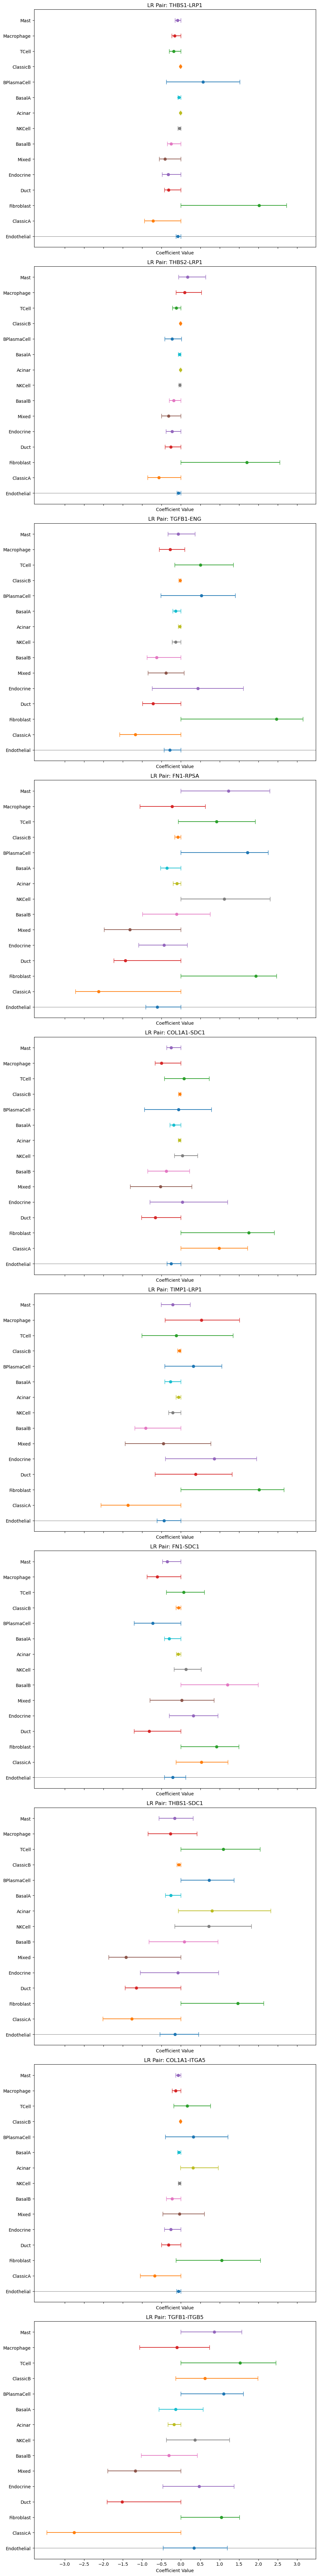

In [112]:
plot_combined_cis_and_means(confidence_df, coef_mean_df)

#### Color bar style - under construction

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# from matplotlib.colors import LinearSegmentedColormap


In [107]:
# def plot_coefficients(df_cis, df_means):
#     # Determine the number of cell types and LR pairs
#     cell_types = df_means.columns
#     lr_pairs = df_means.index

#     # Create the plot
#     fig, ax = plt.subplots(figsize=(10, len(lr_pairs) * 2))  # Adjust size as necessary

#     # Color map from red to blue
#     cmap = mcolors.LinearSegmentedColormap.from_list("coeff_map", ["blue", "white", "red"])
#     norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)  # Adjust vmin, vmax accordingly

#     # Iterate through each row and each column to plot
#     for i, lr_pair in enumerate(lr_pairs):
#         for j, cell_type in enumerate(cell_types[1:]):
#             mean = df_means.loc[lr_pair, cell_type]
#             ci_low, ci_high = df_cis.loc[lr_pair, cell_type]
#             color = cmap(norm(mean))
#             ax.errorbar(j, i, xerr=[[mean - ci_low], [ci_high - mean]], fmt='o', color=color, capsize=5)
#             ax.text(j, i, f'{mean:.2f}', color='black', ha='center', va='center')

#     # ax.set_yticks(range(len(lr_pairs)))
#     # ax.set_yticklabels(lr_pairs)
#     # ax.set_xticks(range(len(cell_types[1:])))
#     # ax.set_xticklabels(cell_types[1:], rotation=90)
#     # ax.invert_yaxis()  # Invert y-axis to have the first entry on top

#     plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#     plt.tight_layout()
#     plt.show()
        

# plot color bars for a given set of LR and cell types coefficients table
def plot_coefficients(df_cis):
    # num_lr_pairs = len(df_cis)
    # fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(10, 8 * num_lr_pairs), sharex=True) # define the number of rows and columns in the plot

    # Determine the number of cell types and LR pairs
    cell_types = df_cis.columns
    lr_pairs = df_cis.index

    # Color map from red to blue
    cmap = mcolors.LinearSegmentedColormap.from_list("coeff_map", ["blue", "white", "red"])
    norm = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)  # Depends on the max/min of the coefficients

    # Iterate through each row and each column to plot
    colorbar_list = []
    for i, lr_pair in enumerate(lr_pairs):
        for j, cell_type in enumerate(cell_types[1:]):
            ci_low = df_cis.iloc[i, j+1][0]
            ci_high = df_cis.iloc[i, j+1][1]
            color = cmap(norm((ci_low + ci_high) / 2))
            fig,axs = plt.subplots(figsize=(4,1))
            axs.set_title(f'LR Pair: {lr_pair}, Cell_type: {cell_type}')
            # plot color bar for each cell type, with the color representing the coefficient value
            cax = axs.imshow([[ci_low, ci_high]], cmap=cmap, norm=norm)
            colorbar_list.append(cax)
            # axs[i,j].label_outer()
            # fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        fig.colorbar(colorbar_list, ax=axs, orientation='horizontal')
        fig.tight_layout()
        fig.show()

    
        


    # ax.set_yticks(range(len(lr_pairs)))
    # ax.set_yticklabels(lr_pairs)
    # ax.set_xticks(range(len(cell_types[1:])))
    # ax.set_xticklabels(cell_types[1:], rotation=90)
    # ax.invert_yaxis()  # Invert y-axis to have the first entry on top

    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    # plt.tight_layout()
    # plt.show()






AttributeError: 'list' object has no attribute 'cmap'

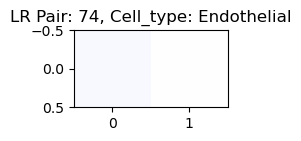

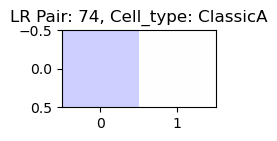

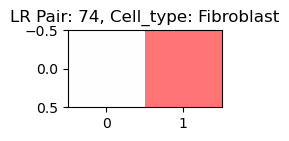

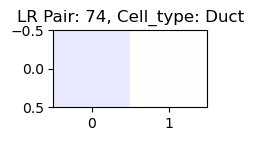

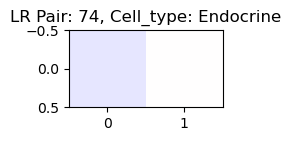

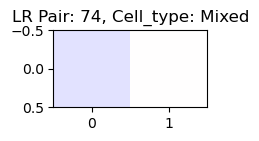

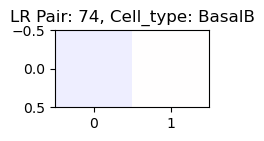

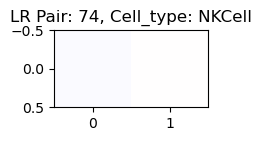

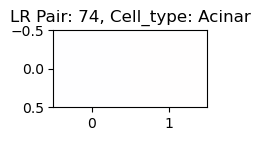

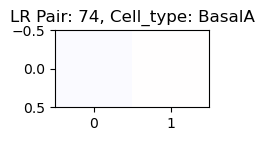

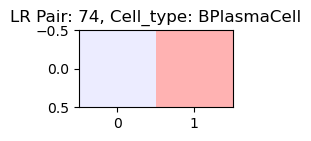

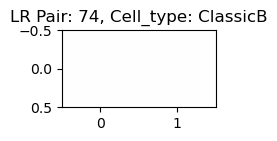

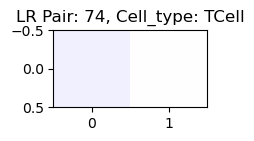

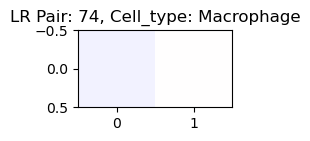

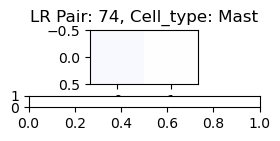

In [108]:

# Call the plotting function
plot_coefficients(confidence_df)

In [38]:
#### Try something from online

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

/var/folders/b0/dbz12pb13hg1zrjq45vwhc680000gn/T/ipykernel_5510/778486756.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)
/var/folders/b0/dbz12pb13hg1zrjq45vwhc680000gn/T/ipykernel_5510/778486756.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


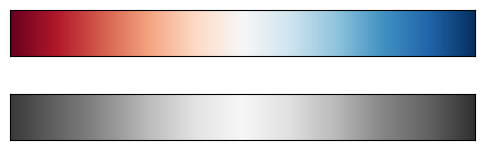

In [40]:
view_colormap('RdBu')

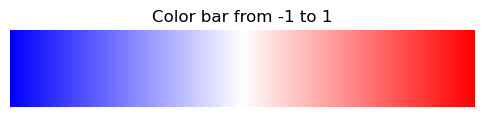

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = ["blue", "white", "red"]  # Colors from -1 to 1
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

# Create a gradient image based on the colormap
gradient = np.linspace(-1, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

# Plotting
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_title('Color bar from -1 to 1')
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

# Create a color bar
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, orientation='horizontal', ticks=[-1, 0, 1])

plt.show()
